In [3]:
import random as rd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("ggplot")
get_ipython().magic('matplotlib inline')
from math import *
import numpy as np
import pickle as pkl
import skimage as ski
from skimage.color import rgb2gray
from scipy import misc
from PIL import Image
import PIL.ImageOps
from skimage.exposure import adjust_gamma
from randomwalkmaker import *
from scipy.integrate import odeint


In [4]:
class Cell:
    def __init__(self, pop_list,  pixelXmeters, mooselim, beaverlim): #pop_list is array, veg_type is string, veg_value is the vegetation index value, hum_value is the humidity value
        self.moose_lim_per_box = mooselim*(pixelXmeters**2)/1000000
        self.beaver_lim_per_box = beaverlim*(pixelXmeters**2)/1000000
        self.pop_list  = pop_list

        self.W = pop_list[0]  # e  = eggs    - aquatic steps
        self.M = pop_list[1]  # l  = larvae  - aquatic steps
        self.B = pop_list[2]  # p  = pupae   - aquatic steps
        
        self.dt = 1/1000
        #U for dying P for passing
        self.a = 5
        self.b = .03
        self.c = 10
        self.d = .02
        self.b1 = .1
        self.d1 = .05
        self.e = .4
        self.h = .5
        self.Mpref = 0.8
        self.Bpref = 1-self.Mpref

    def step(self):
        
        mooselog  = (1 - self.M/self.moose_lim_per_box)
        beaverlog = (1 - self.B/self.beaver_lim_per_box)
        
        deltam =  (self.a*self.M*mooselog  - self.b*self.W*self.M/(1+self.b*self.M*self.Mpref))*self.dt #moose value update
        deltab =  (self.c*self.B*beaverlog - self.d*self.W*self.B/(1+self.d*self.B*self.Bpref))*self.dt # beaver value update
        deltaw =  (self.b1*self.b*self.W*self.M/(1+self.b*self.M*self.Mpref) + self.d1*self.d*self.W*self.B/(1+self.d*self.B*self.Bpref)  - self.e*self.W)*self.dt                             
        
        self.M += deltam
        self.B += deltab
        self.W += deltaw
        
        if self.M <0 : self.M = 0
        if self.B <0 : self.B = 0
        if self.W <0 : self.W = 0
        
        
        
    def update(self):
        for i in range(int(1/self.dt)): self.step()
    

        
        
        
        
        


0.1


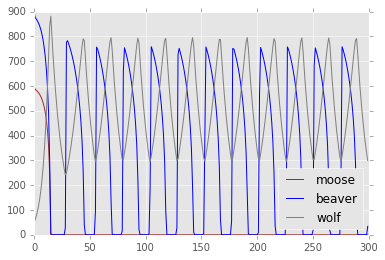

0.128571428571


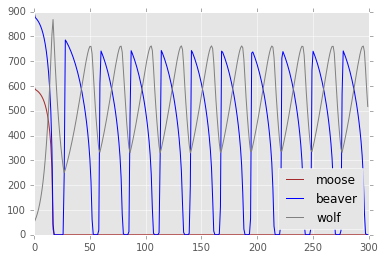

0.157142857143


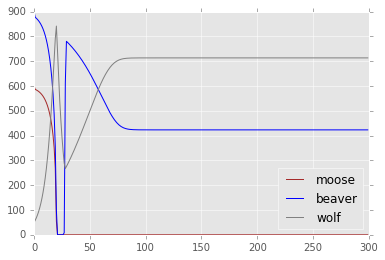

0.185714285714


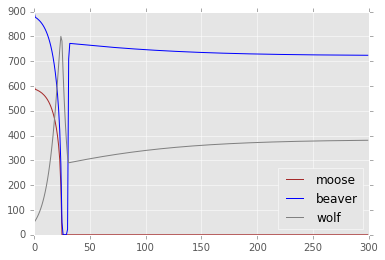

0.214285714286


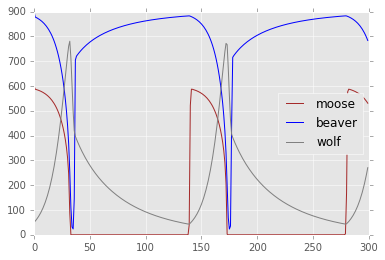

0.242857142857


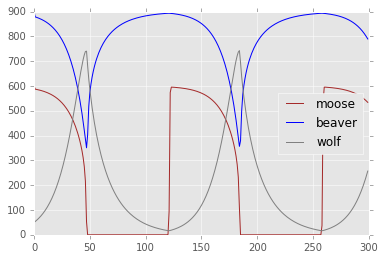

0.271428571429


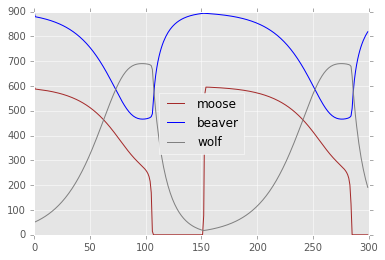

0.3


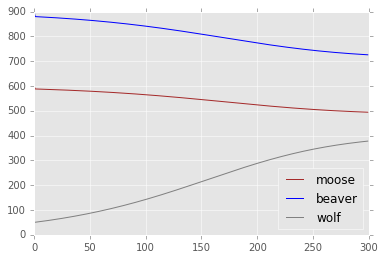

0.328571428571


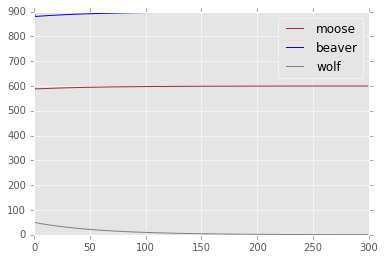

0.357142857143


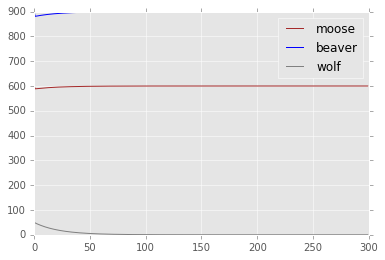

0.385714285714


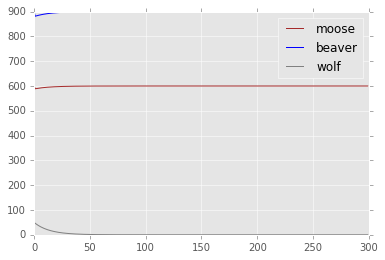

0.414285714286


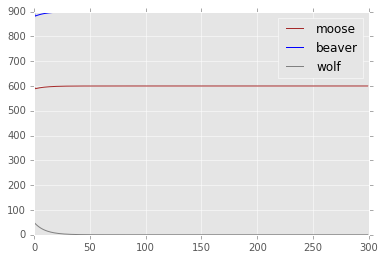

0.442857142857


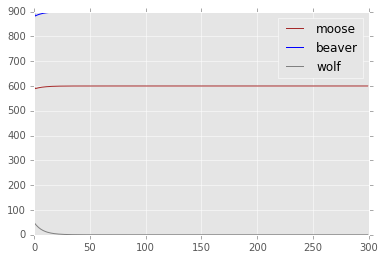

0.471428571429


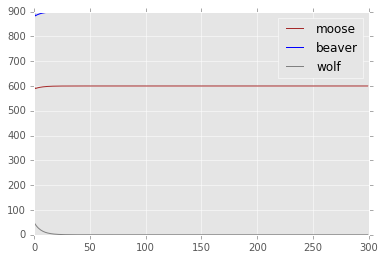

0.5


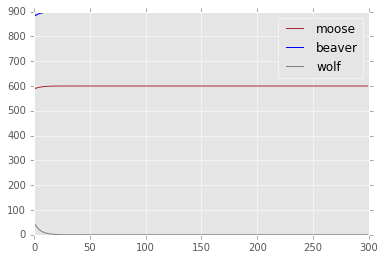

In [5]:
time = 300

for deathW in np.linspace(.1, .5, 15):
    eco = Cell([50, 600 , 900], 1000, 600, 900)
    mooselist = [eco.M]
    beaverlist = [eco.B]
    wolflist = [eco.W]
    eco.e = deathW
    for i in range(time-1):
        eco.update()
        mooselist  += [eco.M]
        beaverlist += [eco.B]
        wolflist   += [eco.W]
        
    print(deathW)
    plt.plot(range(time), mooselist, color = 'brown', label='moose')
    plt.plot(range(time), beaverlist, color = 'blue', label='beaver')
    plt.plot(range(time), wolflist, color = '.5' , label='wolf')
    plt.legend(loc = 'best')
    plt.show()
        

In [ ]:
class Grid:
    def __init__(self, contour, vegimage, twiimage, cityimage, pixelXmeters, larvaelim, gmotype):
        self.internalclock = 0
        self.shape = contour.shape
        self.contour = contour
        self.vegimage = abs(vegimage-1)
        self.twiimage = abs(twiimage-1)
        self.cityimage = cityimage
        self.pixelSize = pixelXmeters
        self.history = []
        
        
        #build the migration dictionaries
        self.maxstep = MaxStep(pixelXmeters)       
        print("migration dt = "+ str(self.maxstep/60))
        self.dict_matrix_to_num, self.dict_num_to_weights = weightDictmaker(self.maxstep, 10000,pixelXmeters)
        
        #calculate stable popvalues
        stable = Cell(np.array([100,100,100,100,100,100]),1,self.vegimage.mean(),self.twiimage.mean(),1, pixelXmeters, larvaelim, gmotype)
        for i in range(300): stable.update()

        #initializing grid of Cells
        self.GRID = [[Cell(np.array(stable.pop_list)*abs(1-contour[j][i]), cityimage[j][i], vegimage[j][i], twiimage[j][i], contour[j][i], pixelXmeters, larvaelim, gmotype) for i in range(self.shape[1])] for j in range(self.shape[0])]

        #create grid of types of contour
        def neighbors_to_tuple(y,x):
            return(int(contour[y-1,x-1]), int(contour[y,x-1]), int(contour[y+1,x-1]), int(contour[y-1,x]), int(contour[y+1,x]), int(contour[y-1,x+1]), int(contour[y,x+1]), int(contour[y+1,x+1]))
        self.bordertype = [[self.dict_matrix_to_num[neighbors_to_tuple(j,i)] for i in range(1,self.shape[1]-1)] for j in range(1,self.shape[0]-1)]
        self.bordertype = np.pad(self.bordertype, pad_width=((1,1),(1,1)), mode='constant', constant_values=-1) #padding with zeros
        
        #equalize values 
        for i in range(10):
            self.updateall()
        self.internalclock = 0
        self.history = []

        print("equilized population")
        print("equilized migration")
        
        self.maxafem = self.getSingleGrid("adult").max()
        self.maxmut  = self.getSingleGrid("amut").max()
        self.maxaqua = self.getSingleGrid("aqua").max() + self.getSingleGrid("aquamut").max()
        
    def getSingleGrid(self, ending):
        if ending == "e"    :  return np.array([[self.GRID[j][i].e  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "l"    :  return np.array([[self.GRID[j][i].l  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "p"    :  return np.array([[self.GRID[j][i].p  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ah"   :  return np.array([[self.GRID[j][i].ah for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ar"   :  return np.array([[self.GRID[j][i].ar for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ao"   :  return np.array([[self.GRID[j][i].ao for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "aqua" : return self.getSingleGrid("e")   + self.getSingleGrid("l") + self.getSingleGrid("p")
        if ending == "adult": return self.getSingleGrid("ah")  + self.getSingleGrid("ar")+ self.getSingleGrid("ao")
        if ending == "all"  : return self.getSingleGrid("aqua")+ self.getSingleGrid("adult")
        if ending == "amale": return np.array([[self.GRID[j][i].amale for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "amut" : return np.array([[self.GRID[j][i].amut for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "aquamut": return np.array([[self.GRID[j][i].emut+self.GRID[j][i].lmut+self.GRID[j][i].pmut  for i in range(self.shape[1])] for j in range(self.shape[0])])
        print("wrong command on getSingleGrid"); return np.array([[]])
        
    def grdsum(self, ending):
        grid_to_sum = self.getSingleGrid(ending)
        return grid_to_sum.sum()
        
    def update_pop(self):
        [[self.GRID[j][i].update() for i in range(self.shape[1])] for j in range(self.shape[0])]
    
    def update_migration(self):
        updatedah   = np.zeros(self.shape)
        updatedao   = np.zeros(self.shape)
        updatedamale = np.zeros(self.shape)
        updatedamut  = np.zeros(self.shape)
        for i in range(1, self.shape[0]-1):
            for j in range(1, self.shape[1]-1):
                if self.GRID[i][j].iswater == 0:
                    borderMatrix = np.array(self.dict_num_to_weights[self.bordertype[i][j]])
                    
                    floatingah = self.GRID[i][j].ah * borderMatrix * self.vegimage[i-1:i+2,j-1:j+2]
                    if floatingah.sum() > 0.05: 
                        updatedah[i-1:i+2,j-1:j+2]   += floatingah*(self.GRID[i][j].ah/floatingah.sum())
                    else: updatedah[i-1:i+2,j-1:j+2] += self.GRID[i][j].ah * borderMatrix 
                            
                    floatingao = self.GRID[i][j].ao * borderMatrix * self.twiimage[i-1:i+2,j-1:j+2]
                    if floatingao.sum() > 0.05: 
                        updatedao[i-1:i+2,j-1:j+2]  += floatingao*(self.GRID[i][j].ao/floatingao.sum())
                    else:updatedah[i-1:i+2,j-1:j+2] += self.GRID[i][j].ao * borderMatrix
                        
                    updatedamale[i-1:i+2,j-1:j+2]  += self.GRID[i][j].amale * borderMatrix  
                    updatedamut[i-1:i+2,j-1:j+2]   += self.GRID[i][j].amut  * borderMatrix
                    
        for i in range(1, self.shape[0]-1):
            for j in range(1, self.shape[1]-1):
                self.GRID[i][j].ah = updatedah[i][j]
                self.GRID[i][j].ao = updatedao[i][j]
                self.GRID[i][j].amale = updatedamale[i][j]
                self.GRID[i][j].amut = updatedamut[i][j]
    
    def updateall(self):
        for i in range(int(24*60/self.maxstep)):
            self.update_migration()
        self.update_pop()
        self.internalclock += 1
        self.history += [(self.grdsum("adult"),self.grdsum("amut") )]
        
    def images(self):
        f, (aquatics, ao, adults) = plt.subplots(ncols=3, figsize=(10,5)) # sharex=True, sharey=True
        caq = aquatics.imshow(self.getSingleGrid('aqua') + self.getSingleGrid('aquamut'), cmap=plt.get_cmap("gist_earth"), vmin = 0, vmax = .8*self.maxaqua)
        aquatics.set_title('Aquatics stages')
        divider1 = make_axes_locatable(aquatics)
        cax1 = divider1.append_axes("bottom", size="5%", pad=0.05)
        f.colorbar(caq,cax1,orientation="horizontal") #  a = int(self.grdsum("aqua") ,ticks = range(0, a, int(a/10)

        cao=ao.imshow(self.getSingleGrid('amut'), cmap=plt.get_cmap("gist_earth"),  vmin = 0, vmax = self.maxafem/.9)
        ao.set_title("Mutant males")
        divider3 = make_axes_locatable(ao)
        cax3 = divider3.append_axes("bottom", size="5%", pad=0.05)
        f.colorbar(cao,cax3, orientation="horizontal")
        
        caa=adults.imshow(self.getSingleGrid('adult'), cmap=plt.get_cmap("gist_earth"),  vmin = 0, vmax = .9*self.maxafem)
        adults.set_title('Adult females')
        divider4 = make_axes_locatable(adults)
        cax4 = divider4.append_axes("bottom", size="5%", pad=0.05)
        f.colorbar(caa,cax4, orientation="horizontal")

        f.subplots_adjust(hspace=0)
        f.suptitle(str(self.internalclock)+" days after release", size = 20)
        plt.setp([a.get_xticklabels() for a in f.axes[:-3]], visible=False)
        plt.setp([a.get_yticklabels() for a in f.axes[:]], visible=False)
        f.tight_layout()
        #f.subplots_adjust(top = 0.999)
        plt.savefig("timelapse/timelapse-"+ '{0:03d}'.format(self.internalclock)+".png")
        plt.show()
        
    def graph(self):
        femalehist, muthist = zip(*self.history)
        plt.plot(range(self.internalclock), femalehist , label = "females")
        plt.plot(range(self.internalclock), muthist    , label = "mutants")
        plt.xlabel('days after mutant release')
        plt.ylabel('population size per square Km')
        plt.title('variation in population size ')
        plt.legend(loc='best', prop={'size':10})
        plt.savefig("timelapse/popsize_variation.png")
        plt.close()
        plt.plot(range(self.internalclock), [femalehist[i]/(2*femalehist[i] + muthist[i]) for i in range(self.internalclock)], label = "females frequency")
        plt.plot( range(self.internalclock),[muthist[i]/(2*femalehist[i]    + muthist[i]) for i in range(self.internalclock)], label = "mutant frequency")
        plt.xlabel('days after mutant release')
        plt.ylabel('percentages')
        plt.ylim(0,1)
        plt.title('mutant and female percentages after release')
        plt.legend(loc='best', prop={'size':10})
        plt.savefig("timelapse/frequency_variation.png")
        plt.close()

                


In [ ]:
island_shape = misc.imread("../example_images/region_border_example.png")
island_shape_gray = rgb2gray(island_shape)
island_wet = ski.img_as_float(rgb2gray(misc.imread("../example_images/TWI_example.png")))
island_veg = ski.img_as_float(rgb2gray(misc.imread("../example_images/vegetation_index_example.png")))
island_city = rgb2gray(misc.imread("../example_images/city_delimitation_example.png"))

In [ ]:
%%time
%time mosquitos = Grid(island_shape_gray, island_veg, island_wet, island_city, 68, 100000, 1)
    
for i in range(-15,15):
    for j in range(-15,15):
        mosquitos.GRID[280+i][140+j].amut = 800
        mosquitos.GRID[200+i][200+j].amut = 800
        mosquitos.GRID[320+i][330+j].amut = 800
        mosquitos.GRID[100+i][300+j].amut = 800


In [ ]:
test = Cell(np.array([10,10,10,10,10,10]),1,1,1,1, 68, 1000000,1 )
ovo = [test.e]
larva= [test.l]
pupa= [test.p]
ahlist= [test.ah]
arlist= [test.ar]
aolist= [test.ao]
amalelist = [test.amale]
amutlist = [test.amut]
adultlist = [test.n_adult]
print(test.amut)
for i in range(250):
    test.update()
    ovo    += [test.e]
    larva  += [test.l]
    pupa   += [test.p]
    adultlist += [test.n_adult]
    amalelist  += [test.amale]
    amutlist  += [test.amut]
    
print(test.pop_list)
test.amut = 10

for i in range(300):
    test.update()
    ovo    += [test.e]
    larva  += [test.l]
    pupa   += [test.p]
    adultlist += [test.n_adult]
    amalelist  += [test.amale]
    amutlist  += [test.amut]
plt.plot(range(len(ovo)),adultlist, label = 'females')
plt.plot(range(len(ovo)), amalelist, label = 'male')
plt.plot(range(len(ovo)), amutlist, label = 'mutant')
#plt.ylim([0, 10000])
plt.xlim([0, 410])
plt.legend(loc = "best")
plt.show()


In [ ]:
mosquitos.grdsum("all")
%time mosquitos.images()
for i in range(10): 
    %time mosquitos.updateall()
    %time mosquitos.images()
%time mosquitos.grdsum("all")
%time mosquitos.graph()